# Setup

In [2]:
import numpy as np
import pandas as pd
from one.api import ONE
from psyfun import io
from psyfun.config import *
from psyfun import plots
import matplotlib as pl
from matplotlib import pyplot as plt

one = ONE()

# only run if first-time setup
# Fetching all session, insertion, and spike data
# DAVIDE: for some reason, fetching keeps getting interrupted by the absence of certain files/directories.
#%run -i fetchdata.py -a

# Load session and insertion metadata
df_sessions = pd.read_parquet(paths['sessions'])
df_insertions = pd.read_parquet(paths['insertions'])

# dropping na (PCA_DC)
df_sessions = df_sessions.query('n_tasks >= 2').dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])

# Create a DataFrame with eids (all sessions with a left vid), categorized by experimental group
eids_exp = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == False), 'eid']
eids_cont = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == True), 'eid']

#------------------------ Functions-------------------------
import os
import numpy as np
import pandas as pd

def download_video(eid, camera = "left"):
    """
    Downloads raw video data from specific session. Camera parameter can be switched to "body" and "right".
    
    Parameters
    ----------
    eid (str): Experiment/session identifier

    camera (str): Camera orientation identifier (left by default). "body", "right" are other available options.

    Returns
    -------
    video_path: Local path for saved video
    """
    
    if camera == "left":
        video_path = one.load_dataset(eid, f'*leftCamera.raw*', collection='raw_video_data')
    elif camera == "right":
        video_path = one.load_dataset(eid, f'*rightCamera.raw*', collection='raw_video_data')
    elif camera == "body":
        video_path = one.load_dataset(eid, f'*bodyCamera.raw*', collection='raw_video_data')
    else:
         raise ValueError(f"Unknown camera parameter: {camera}")

    return video_path

def get_time_epochs(df_sessions, eid):

    video_data = df_sessions.loc[df_sessions['eid'] == eid]
    
    # epochs
    epoch_pre = [
        ("task00_spontaneous", video_data['task00_spontaneous_start'].values[0], video_data['task00_spontaneous_stop'].values[0]),
        ("task00_rfm", video_data['task00_rfm_start'].values[0], video_data['task00_rfm_stop'].values[0]),
        ("task00_replay", video_data['task00_replay_start'].values[0], video_data['task00_replay_stop'].values[0])
    ]

    epoch_post = [
        ("task01_spontaneous", video_data['task01_spontaneous_start'].values[0], video_data['task01_spontaneous_stop'].values[0]),
        ("task01_rfm", video_data['task01_rfm_start'].values[0], video_data['task01_rfm_stop'].values[0]),
        ("task01_replay", video_data['task01_replay_start'].values[0], video_data['task01_replay_stop'].values[0])
    ]

    return epoch_pre, epoch_post


# will be useful for multi-video analysis at the end
def load_pca_results(results, eid, epoch_name):
    """
    Imports MotionMap results on motion energy video analysis. Obtains path for .npy file based on eid, loads, and returns the data
    in a dataframe. a

    Parameters
    ----------
    results: pd.DataFrame
        Dataframe containing PCA results containing eid, epoch_name, savename
    eid: str
        Experiment/session identifier.
    epoch_name: str
        Epoch identifier. Can take the values of 'spontaneous','rfm', or 'replay'

    Returns
    -------
    pre, post = pd. Dataframe
        MotionMap results for pre/post particular epochs.
    """
        

    path_df = results[results['eid'] == eid]

    if epoch_name == 'spontaneous':
        pre = np.load(path_df[path_df['epoch'] == 'pre_spo']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_spo']['savename'].values[0], allow_pickle=True).item()

    elif epoch_name == 'rfm':
        pre = np.load(path_df[path_df['epoch'] == 'pre_rfm']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_rfm']['savename'].values[0], allow_pickle=True).item()

    elif epoch_name == 'replay':
        pre = np.load(path_df[path_df['epoch'] == 'pre_rep']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_rep']['savename'].values[0], allow_pickle=True).item()

    else:
        raise NameError(f"Epoch name not recognized {epoch_name}")
    return pre, post


### setup experimental

In [3]:
# Import dataframe with PCA results entries (eid, epoch_name, filepath)
exp_results = pd.read_csv(r'C:\Users\marti\Documents\mainen\psychedelics\video\exp_results')

# Correct the epoch_name for easier access (otherwise interval stamps mess up possible grouping)
# Assumes consecutive loading (each eid, 6 sorted epochs)
epoch_naming = ['pre_spo', 'pre_rfm', 'pre_rep', 'post_spo', 'post_rfm', 'post_rep']

for eid, group in exp_results.groupby('eid'):
    idx = group.index
    if len(idx) == len(epoch_naming):
        exp_results.loc[idx, 'epoch'] = epoch_naming
    else:
        print(f"Warning: eid {eid} has {len(idx)} entries, expected {len(epoch_naming)}")

### setup control

In [4]:
# Import dataframe with PCA results entries (eid, epoch_name, filepath)
cont_results = pd.read_csv(r'C:\Users\marti\Documents\mainen\psychedelics\video\cont_results')

# Correct the epoch_name for easier access (otherwise interval stamps mess up possible grouping)
# Assumes consecutive loading (each eid, 6 sorted epochs)
epoch_naming = ['pre_spo', 'pre_rfm', 'pre_rep', 'post_spo', 'post_rfm', 'post_rep']

for eid, group in cont_results.groupby('eid'):
    idx = group.index
    if len(idx) == len(epoch_naming):
        cont_results.loc[idx, 'epoch'] = epoch_naming
    else:
        print(f"Warning: eid {eid} has {len(idx)} entries, expected {len(epoch_naming)}")

In [5]:
def get_eigen(epoch_result, reshaped = False):

    # Temporal masks: full video, frame-level SVD (frame x component)
    frame_masks = epoch_result['motSVD']
    frame_masks = np.stack(frame_masks[0], axis = 0) 
    print("Temporal PC matrix has shape", frame_masks.shape)
    # Eigenfaces: each 
    eigenmsk = epoch_result['motMask'] # binned pixels x components
    eigenmsk=np.stack(eigenmsk[0], axis = 0)
    print("Eigenmask matrix has shape ", eigenmsk.shape)


    # singular values: they are in order (sanity check)
    eigenval = epoch_result['motSv']**2
    print("singular value array has shape ", eigenval.shape)

    if reshaped:
        # Reshaped eigenfaces
        re_eigenmsk = epoch_result['motMask_reshape'] # reshaped by bins (x, y, components)
        re_eigenmsk=np.stack(re_eigenmsk[0], axis = 0)
        return re_eigenmsk, frame_masks, eigenval
    else:
        return eigenmsk, frame_masks, eigenval

# Analysis

(array([[252.,   3.,   0., ...,   0.,   1.,   0.],
        [251.,   5.,   0., ...,   0.,   0.,   0.],
        [249.,   7.,   0., ...,   0.,   0.,   0.],
        ...,
        [253.,   3.,   0., ...,   0.,   0.,   0.],
        [256.,   0.,   0., ...,   0.,   0.,   0.],
        [256.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.        , 0.95663512, 1.91327024, 2.86990523, 3.82654047,
        4.78317547, 5.73981047, 6.69644547, 7.65308094, 8.60971546,
        9.56635094]),
 <a list of 320 BarContainer objects>)

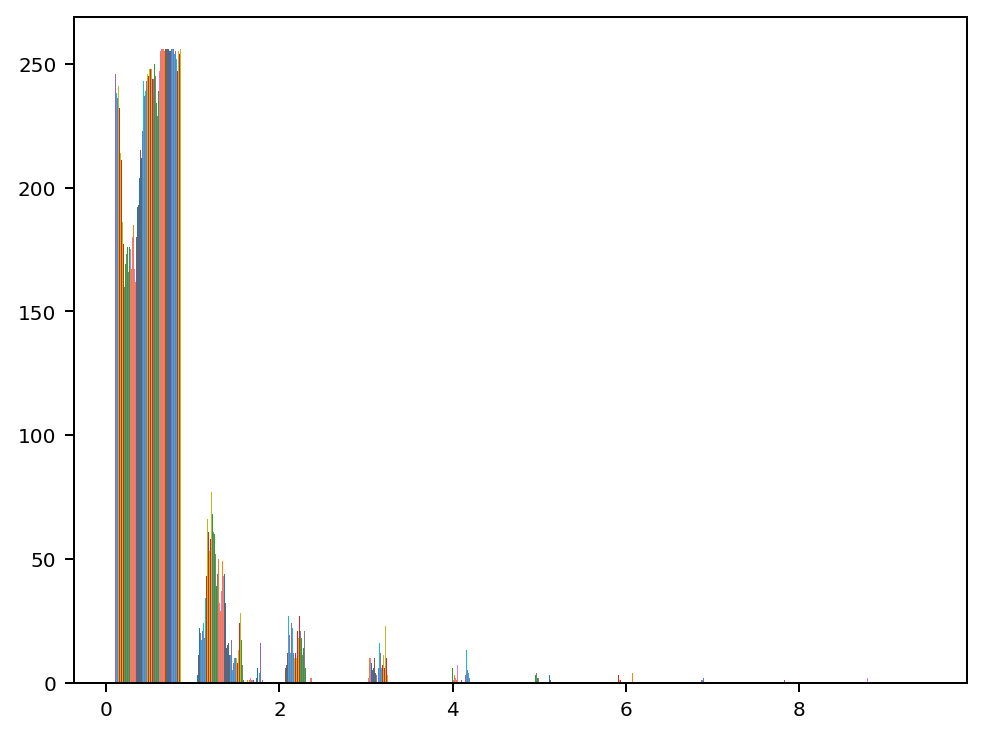

In [6]:
eid1 = exp_results['eid'].unique()[0]

pre1, post1 = load_pca_results(exp_results, eid1, epoch_name = 'replay')

avg_motion_pre = pre1.get('avgmotion_reshape')
avg_motion_post = post1.get('avgmotion_reshape')

# distribution of mean-centered average motion energy
plt.hist(avg_motion_pre)

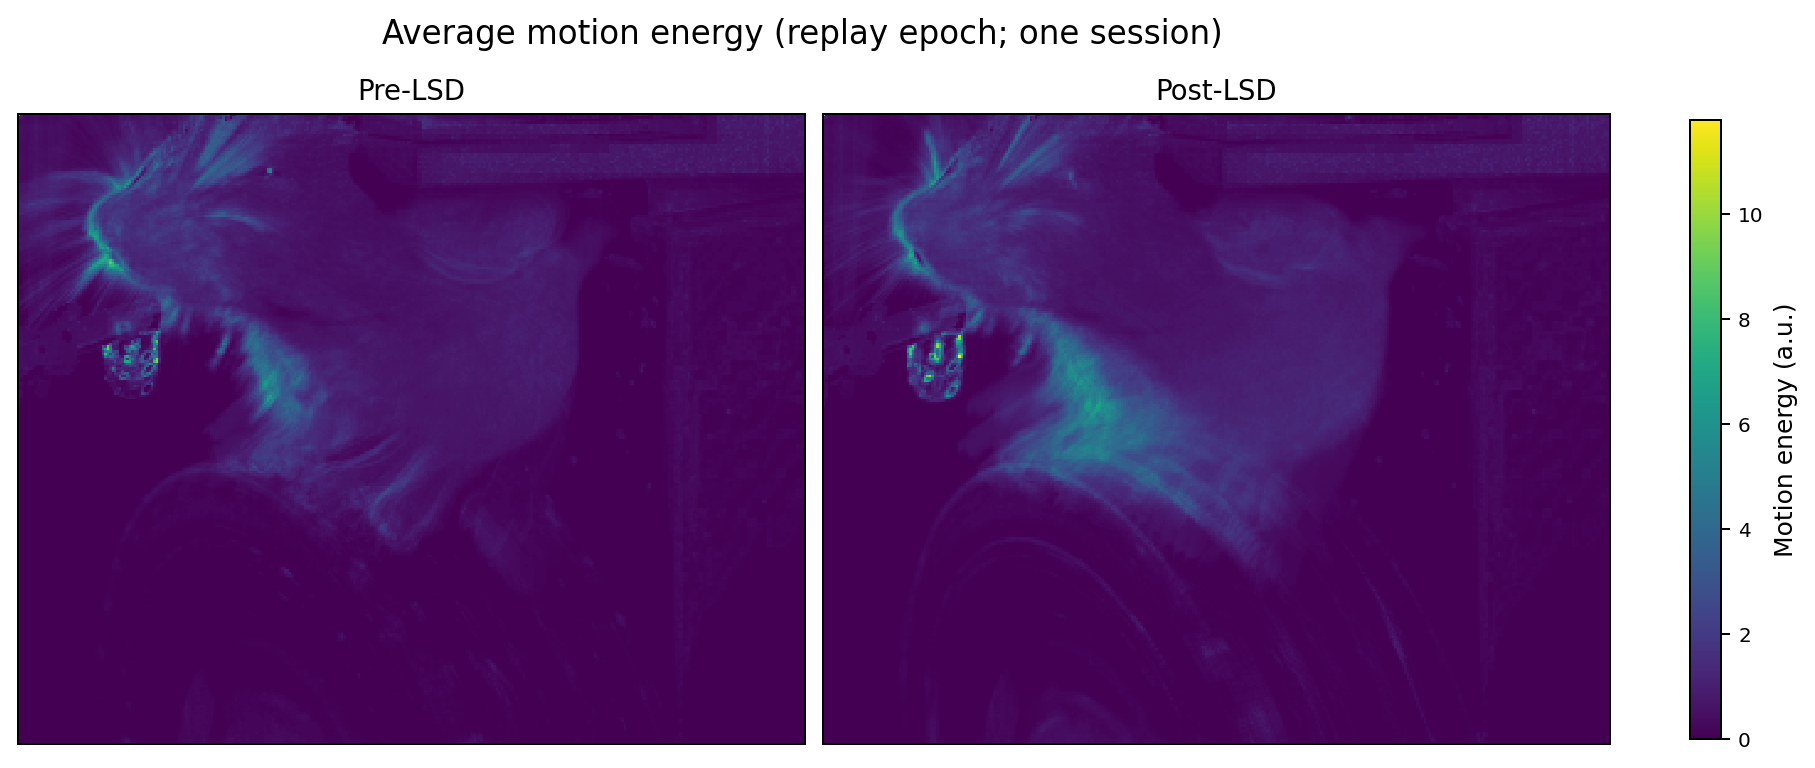

In [13]:
eid1 = exp_results['eid'].unique()[0]

pre1, post1 = load_pca_results(exp_results, eid1, epoch_name = 'replay')

avg_motion_pre = pre1.get('avgmotion_reshape')
avg_motion_post = post1.get('avgmotion_reshape')

import matplotlib.pyplot as plt

# Set clean, readable font style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 11,
    'axes.titleweight': 'normal'
})

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Shared color limits
vmin = min(avg_motion_pre.min(), avg_motion_post.min())
vmax = max(avg_motion_pre.max(), avg_motion_post.max())

# Plot both images with the same colormap
im0 = axs[0].imshow(avg_motion_pre, cmap='viridis', vmin=vmin, vmax=vmax, interpolation='nearest')
im1 = axs[1].imshow(avg_motion_post, cmap='viridis', vmin=vmin, vmax=vmax, interpolation='nearest')

# Style individual subplots
for ax, title in zip(axs, ["Pre-LSD", "Post-LSD"]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    for spine in ax.spines.values():
        spine.set_visible(True)

# Add colorbar
cbar = fig.colorbar(im1, ax=axs, shrink=0.9, location='right')
cbar.set_label('Motion energy (a.u.)', fontsize = 10)

# Centered, clean figure title
fig.suptitle("Average motion energy (replay epoch; one session)", fontsize=13, x = 0.44, y=1.06)

plt.show()


In [10]:
pre_data,_,_ = get_eigen(pre1,reshaped=True)
post_data,_,_ = get_eigen(post1, reshaped = True)


Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (17920, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
(256, 320, 500)


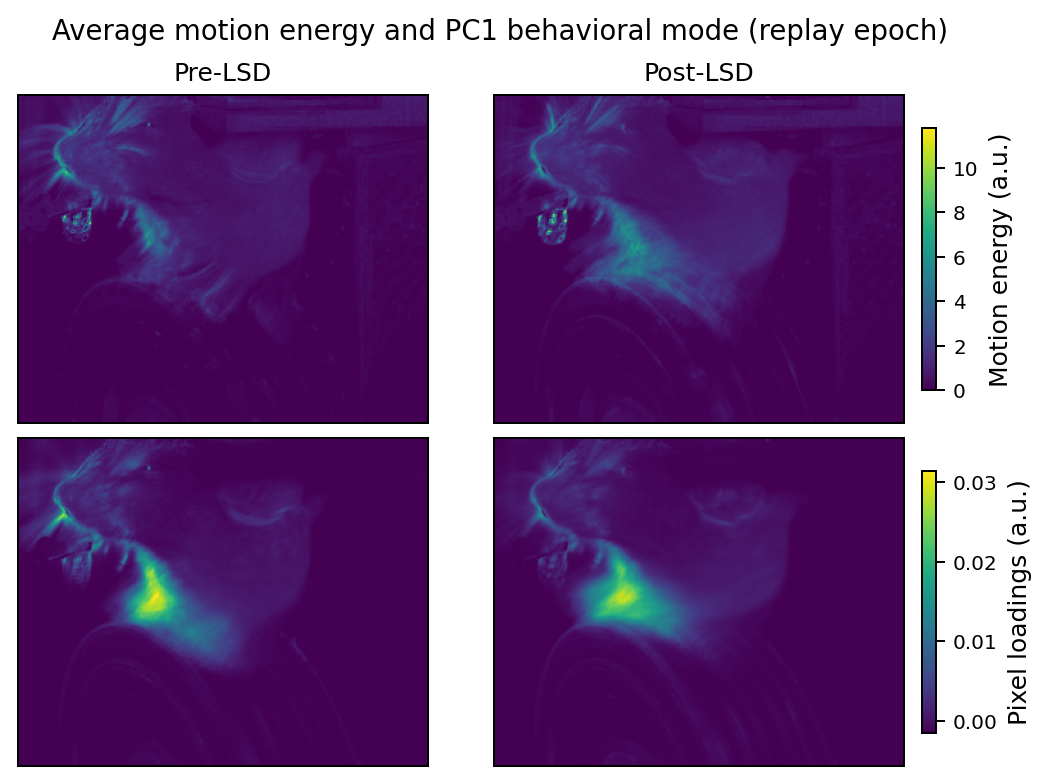

In [70]:
import matplotlib.pyplot as plt

# Font setup
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 11,
    'axes.titleweight': 'normal'
})

# Extract data
PC1_pre = pre_data[:, :, 0]
PC1_post = post_data[:, :, 0]

# Color limits
vmin_pc = min(PC1_pre.min(), PC1_post.min())
vmax_pc = max(PC1_pre.max(), PC1_post.max())
vmin_mot = min(avg_motion_pre.min(), avg_motion_post.min())
vmax_mot = max(avg_motion_pre.max(), avg_motion_post.max())

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 4), constrained_layout=True)
# Plot motion energy maps
im0 = axs[0, 0].imshow(avg_motion_pre, cmap='viridis', vmin=vmin_mot, vmax=vmax_mot)
im1 = axs[0, 1].imshow(avg_motion_post, cmap='viridis', vmin=vmin_mot, vmax=vmax_mot)

# Plot PC1 loading maps
im2 = axs[1, 0].imshow(PC1_pre, cmap='viridis', vmin=vmin_pc, vmax=vmax_pc)
im3 = axs[1, 1].imshow(PC1_post, cmap='viridis', vmin=vmin_pc, vmax=vmax_pc)

# Titles
axs[0, 0].set_title("Pre-LSD", fontsize = 10)
axs[0, 1].set_title("Post-LSD", fontsize = 10)

# Remove ticks and show borders
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)

# Colorbars
cbar0 = fig.colorbar(im0, ax=axs[0, :], orientation='vertical', shrink=0.8, pad=0.02)
cbar0.set_label("Motion energy (a.u.)", fontsize=10)

cbar1 = fig.colorbar(im2, ax=axs[1, :], orientation='vertical', shrink=0.8, pad=0.02)
cbar1.set_label("Pixel loadings (a.u.)", fontsize=10)

# Global title
fig.suptitle("Average motion energy and PC1 behavioral mode (replay epoch)", fontsize=11, y=1.05)

plt.show()


### maybe plot for both???

In [6]:
exp_pre = []
exp_post = []
for eid in cont_results['eid'].unique():

#eidx = exp_results['eid'].unique()[0]

#replay
    pre, post = load_pca_results(cont_results, eid, epoch_name='replay')

    pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
    post_eigenmsk, _, post_eigenval = get_eigen(post)

    pre_explained_ratio = pre_eigenval/(pre_eigenval.sum())

    comp_pre = np.searchsorted(pre_explained_ratio.cumsum(), 0.8)+1
    exp_pre.append(comp_pre)

    print("First pre component explains: ", pre_explained_ratio[0])
    post_explained_ratio = post_eigenval/(post_eigenval.sum())

    comp_post = np.searchsorted(post_explained_ratio.cumsum(), 0.8)+1
    exp_post.append(comp_post)
    print("First postcomponent explains: ", post_explained_ratio[0])


Temporal PC matrix has shape (18780, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (16744, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
First pre component explains:  0.19366126
First postcomponent explains:  0.18130246
Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (13837, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
First pre component explains:  0.24333078
First postcomponent explains:  0.21965095
Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18780, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
First pre component explains:  0.22311313
First postcomponent explains:  0.2121737
Temporal PC matri

(array([2., 0., 0., 0., 0., 0., 3., 1., 1., 2.]),
 array([102. , 105.5, 109. , 112.5, 116. , 119.5, 123. , 126.5, 130. ,
        133.5, 137. ]),
 <BarContainer object of 10 artists>)

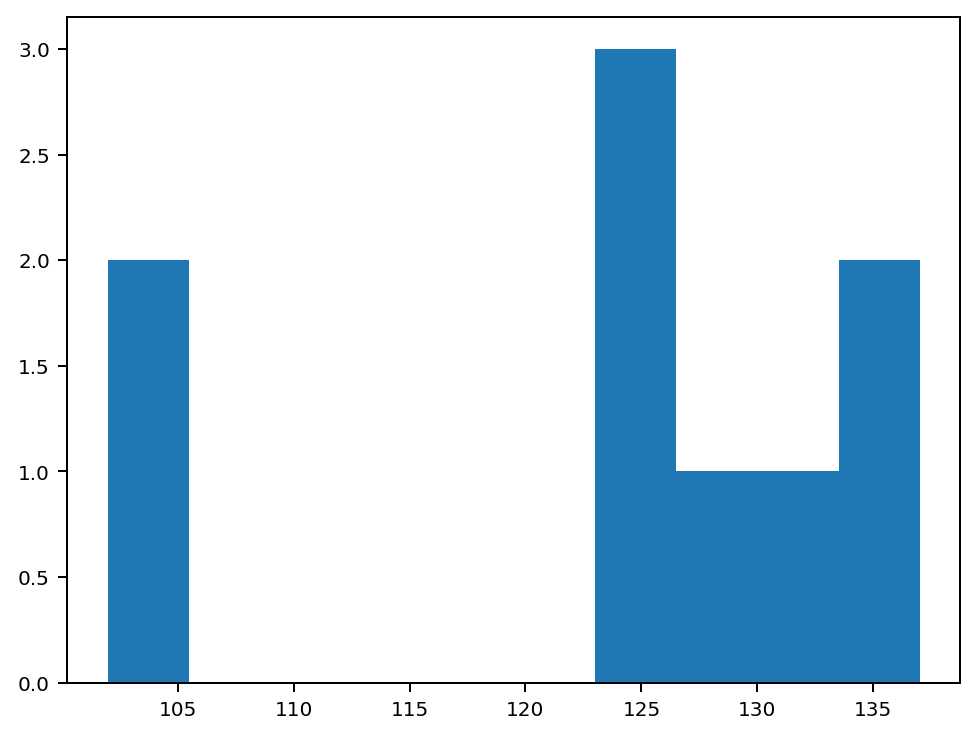

In [7]:
plt.hist(exp_pre)

(array([1., 0., 0., 0., 0., 2., 2., 2., 1., 1.]),
 array([100. , 103.7, 107.4, 111.1, 114.8, 118.5, 122.2, 125.9, 129.6,
        133.3, 137. ]),
 <BarContainer object of 10 artists>)

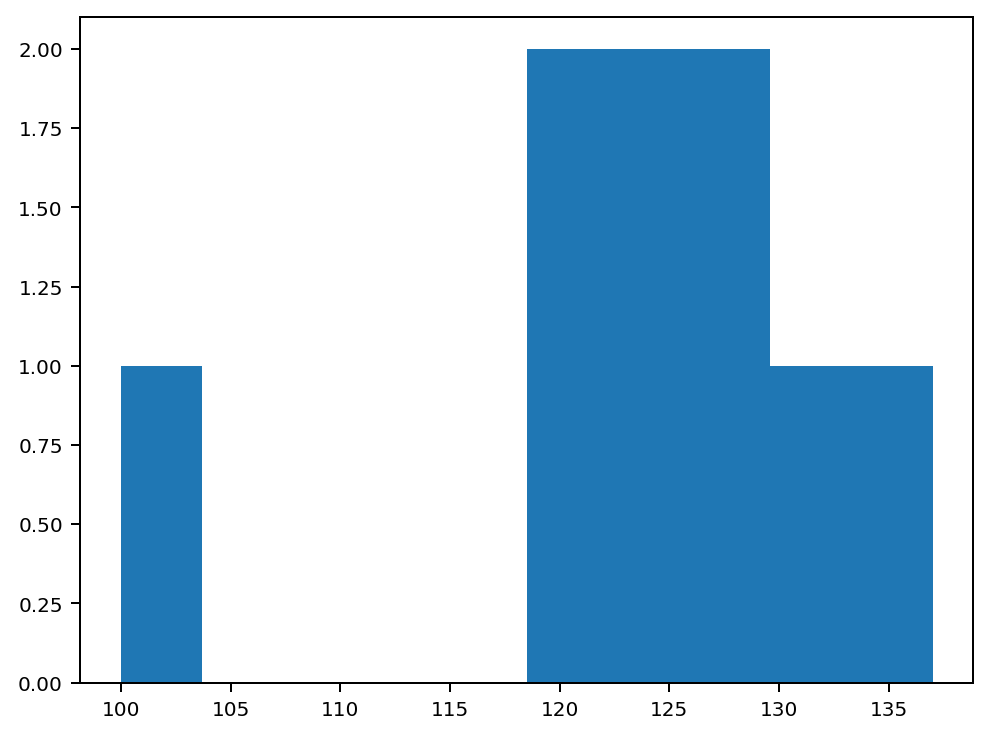

In [8]:
plt.hist(exp_post)

In [9]:
eid = exp_results['eid'].unique()[0]


pre, post = load_pca_results(exp_results, eid, epoch_name='replay')

pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
post_eigenmsk, _, post_eigenval = get_eigen(post)

Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (17920, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)


In [10]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from psyfun import util
k = 150 #<-- components to keep
similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)

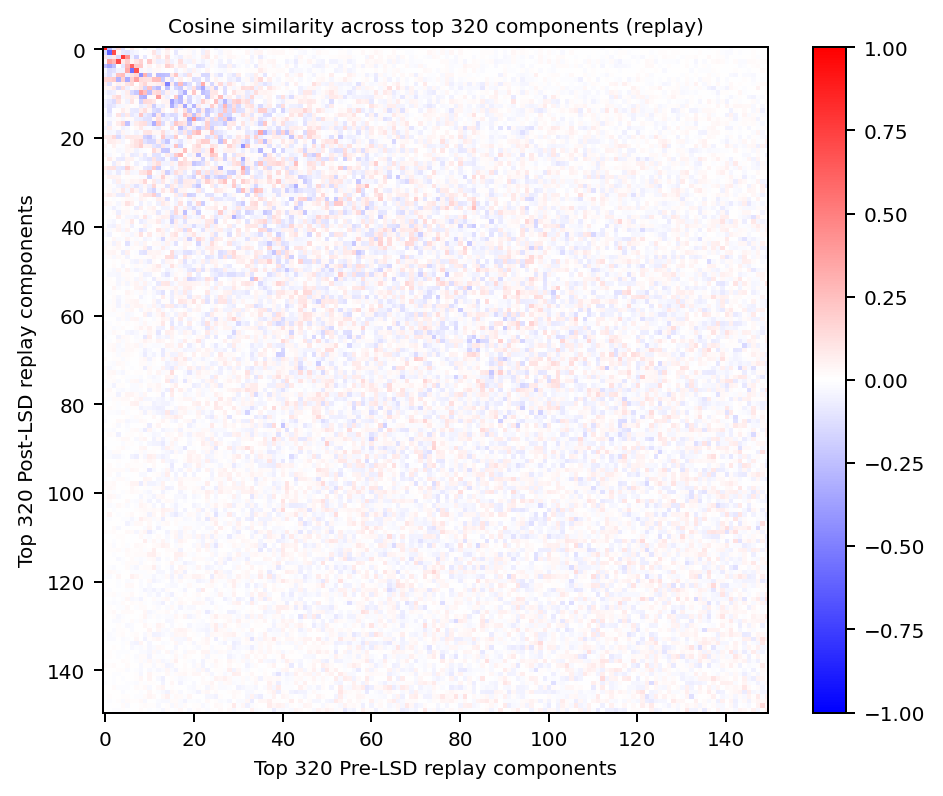

In [11]:
fig, ax0 = plt.subplots()
cax = ax0.imshow(similarity_matrix, cmap='bwr', vmin=-1, vmax=1)
ax0.set_title("Cosine similarity across top 320 components (replay)")
ax0.set_xlabel("Top 320 Pre-LSD replay components")
ax0.set_ylabel("Top 320 Post-LSD replay components")
fig.colorbar(cax, ax=ax0)
plt.show()

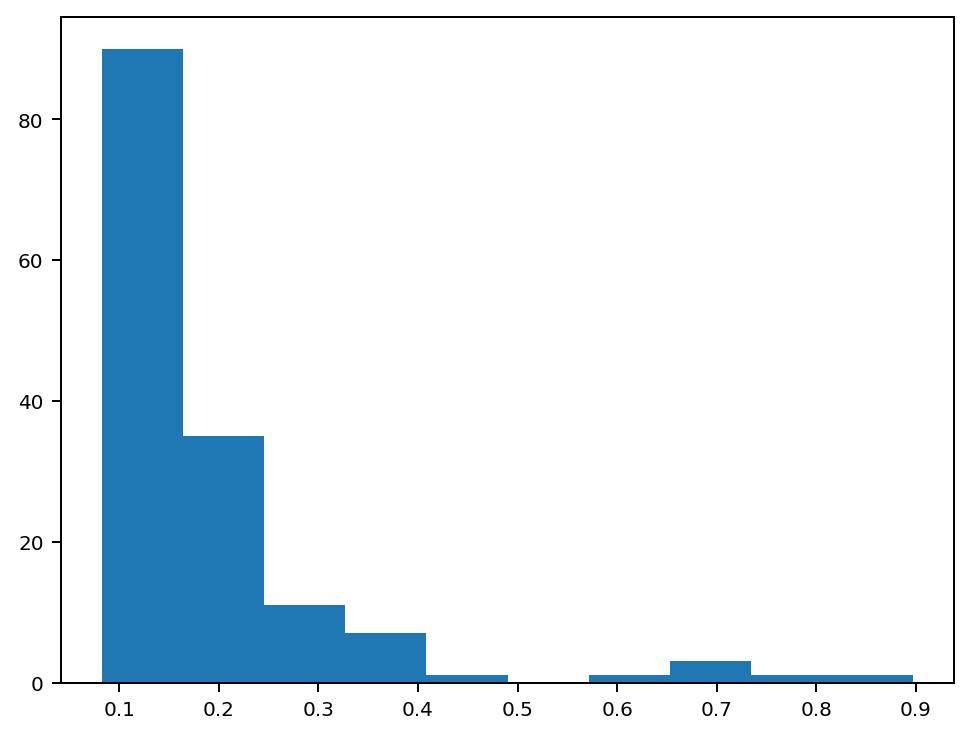

In [12]:
# Each PC's maximal similarity (rowmax) [one epoch]
# careful because it looks non-increasing
max_similarity = np.max(similarity_matrix, axis = 0)

# simply averaging is a bit too much, because the PC (and their variance_explained impacts)
# maybe linear combination with their explained_variance ratio
plt.hist(max_similarity)
plt.show()

## average case

In [21]:
## experimental case
experimental = []
from sklearn.metrics.pairwise import cosine_similarity
from psyfun import util


for eid in exp_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        #eidx = exp_results['eid'].unique()[0]

        pre, post = load_pca_results(exp_results, eid, epoch_name=epoch)

        pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
        post_eigenmsk, _, post_eigenval = get_eigen(post)

        # cosine similarity

        k = 150 #<-- components to keep
        similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)
        
        # rowmax list
        max_similarity = np.max(similarity_matrix, axis = 0)

        # average value
        experimental.append((eid, epoch, np.mean(max_similarity)))

   

Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (23040, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (24180, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (17920, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has s

In [23]:
## control case
control = []
from sklearn.metrics.pairwise import cosine_similarity
from psyfun import util

for eid in cont_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        pre, post = load_pca_results(cont_results, eid, epoch_name=epoch)

        pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
        post_eigenmsk, _, post_eigenval = get_eigen(post)

        # cosine similarity

        k = 150 #<-- components to keep
        similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)
        
        # rowmax list
        max_similarity = np.max(similarity_matrix, axis = 0)

        # average value
        control.append((eid, epoch, np.mean(max_similarity)))

   

Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (39360, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (39300, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18780, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (16744, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has s

In [26]:
# replay cosine similarity comparison

exp_data = pd.DataFrame(experimental, columns = ['eid', 'epoch', 'avg_sim'])
control_data = pd.DataFrame(control, columns = ['eid', 'epoch', 'avg_sim'])


In [43]:
exp_data

,eid,epoch,avg_sim,condition
0,58ca39c5-e27f-43c4-8516-2ccc4fe88042,spontaneous,0.142170,exp
1,58ca39c5-e27f-43c4-8516-2ccc4fe88042,rfm,0.228823,exp
2,58ca39c5-e27f-43c4-8516-2ccc4fe88042,replay,0.190197,exp
3,7149e0fc-a52d-4e93-849c-edc22d54e7a5,spontaneous,0.183446,exp
4,7149e0fc-a52d-4e93-849c-edc22d54e7a5,rfm,0.177385,exp
...,...,...,...,...
76,4e3f021c-e553-4c67-988a-0ca52535748e,rfm,0.173391,exp
77,4e3f021c-e553-4c67-988a-0ca52535748e,replay,0.165617,exp
78,895fd80e-bb8a-4154-bd1f-436e6b8e1030,spontaneous,0.139879,exp
79,895fd80e-bb8a-4154-bd1f-436e6b8e1030,rfm,0.167151,exp


In [51]:
from scipy import stats
import seaborn as sns
exp_val = exp_data['avg_sim'][exp_data['epoch'] == 'spontaneous']
control_val= control_data['avg_sim'][control_data['epoch'] == 'spontaneous']

ttest = stats.ttest_ind(exp_val, control_val, equal_var=False)
print(ttest)

# t = 0.67, p = 0.51
exp_val = exp_data['avg_sim'][exp_data['epoch'] == 'rfm']
control_val= control_data['avg_sim'][control_data['epoch'] == 'rfm']

ttest = stats.ttest_ind(exp_val, control_val, equal_var=False)
print(ttest)

#t = 1.29, p=  0.21

exp_val = exp_data['avg_sim'][exp_data['epoch'] == 'replay']
control_val= control_data['avg_sim'][control_data['epoch'] == 'replay']

ttest = stats.ttest_ind(exp_val, control_val, equal_var=False)
print(ttest)
# t = -0.21, p = 0.83


TtestResult(statistic=0.6709078308655315, pvalue=0.5156810279458468, df=11.36650772329466)
TtestResult(statistic=1.293692866935411, pvalue=0.21770128348732257, df=13.353669476400647)
TtestResult(statistic=-0.21377060770694165, pvalue=0.8323058381293433, df=27.450391624079042)


In [29]:
from scipy import stats
import pingouin as pg

exp_data['condition'] = 'exp'
control_data['condition'] = 'control'

all_data = pd.concat([exp_data, control_data], ignore_index=True)

anova = pg.mixed_anova(
                        dv = 'avg_sim',
                        within ='epoch',
                        between = 'condition',
                        subject = 'eid',
                        data = all_data)

print(anova)



        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0    condition  0.000772    1   34  0.000772   0.693721  0.410714  0.019996   
1        epoch  0.013311    2   68  0.006656  14.526808  0.000006  0.299356   
2  Interaction  0.000764    2   68  0.000382   0.833323  0.438992  0.023923   

        eps  
0       NaN  
1  0.985882  
2       NaN  


c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


C:\Users\marti\AppData\Local\Temp\ipykernel_37328\1980582348.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.pointplot(data=all_data, x='epoch', y='avg_sim', hue='condition', ci=68)


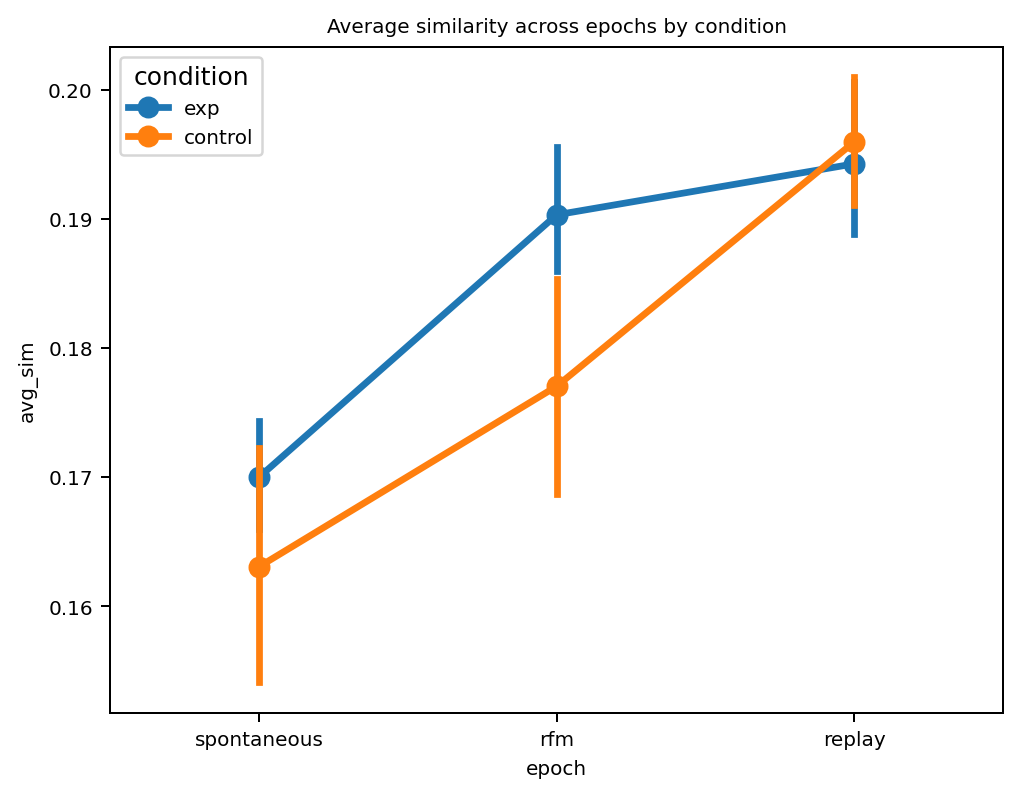

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pointplot(data=all_data, x='epoch', y='avg_sim', hue='condition', ci=68)
plt.title('Average similarity across epochs by condition')
plt.ylabel('avg_sim')
plt.show()


post hoc

In [41]:
posthoc = pg.pairwise_tests(dv='avg_sim', within='epoch', subject='eid', parametric=True, data=exp_data, padjust='none')
print(posthoc)

  Contrast       A            B  Paired  Parametric         T   dof  \
0    epoch  replay          rfm    True        True  0.620428  26.0   
1    epoch  replay  spontaneous    True        True  3.821110  26.0   
2    epoch     rfm  spontaneous    True        True  3.638286  26.0   

  alternative     p-unc    BF10    hedges  
0   two-sided  0.540377   0.243  0.136547  
1   two-sided  0.000744  44.194  0.894475  
2   two-sided  0.001192  29.191  0.833482  


In [42]:
posthoc = pg.pairwise_tests(dv='avg_sim', within='epoch', subject='eid', parametric=True, data=control_data, padjust='none')
print(posthoc)

  Contrast       A            B  Paired  Parametric         T  dof  \
0    epoch  replay          rfm    True        True  3.132447  8.0   
1    epoch  replay  spontaneous    True        True  3.612277  8.0   
2    epoch     rfm  spontaneous    True        True  1.514435  8.0   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.013964  4.883  0.816554  
1   two-sided  0.006859  8.588  1.365381  
2   two-sided  0.168378  0.761  0.481917  


significant analysis here depends on how these "change" metrics compare to the control case. That way, I could claim some sort of significant behavioral change upon LSD administration

possible next steps:
- subplane similarity analysis. take top k (argmax) components from individual pair cos analysis and compare the basis. This could give a more nuanced comparison in behavioral change, but I'm afraid the angle intuition necessarily get lost.
- the fact that it's two different motif basis is getting on my nerves. Lempel-ziv
